## Work
1. 請改變 reduce_lr 的 patience 和 factor 並比較不同設定下，對訓練/驗證集的影響
2. 請將 optimizer 換成 Adam、RMSprop 搭配 reduce_lr 並比較訓練結果

In [1]:
import os
import keras

Using TensorFlow backend.


In [2]:
train, test = keras.datasets.cifar10.load_data()

In [3]:
## 資料前處理
def preproc_x(x, flatten=True):
    x = x / 255.
    if flatten:
        x = x.reshape((len(x), -1))
    return x

def preproc_y(y, num_classes=10):
    if y.shape[-1] == 1:
        y = keras.utils.to_categorical(y, num_classes)
    return y    

In [4]:
x_train, y_train = train
x_test, y_test = test

# Preproc the inputs
x_train = preproc_x(x_train)
x_test = preproc_x(x_test)

# Preprc the outputs
y_train = preproc_y(y_train)
y_test = preproc_y(y_test)

In [5]:
from keras.layers import Input
from keras.layers import Dense
from keras.layers import Dropout
from keras.layers import Activation
from keras.layers import BatchNormalization
from keras.regularizers import l1_l2

def build_mlp(input_shape, output_units=10, num_neurons=[256, 256, 256]):
    input_layer = Input(input_shape)
    x = Dense(units=num_neurons[0],
              activation=None,
              name='hidden_layer_0',
              kernel_regularizer=l1_l2(1e-12,1e-12))(input_layer)
    x = Activation('relu')(x)
    x = BatchNormalization()(x)
    x = Dropout(0.2)(x)
    for i, neurons in enumerate(num_neurons):
        x = Dense(units=neurons,
                  activation=None,
                  name='hidden_layer_{0}'.format(str(i+1)),
                  kernel_regularizer=l1_l2(1e-12,1e-12))(x)
        x = Activation('relu')(x)
        x = BatchNormalization()(x)
        x = Dropout(0.2)(x)
    
    out = keras.layers.Dense(units=output_units, activation="softmax", name="output")(x)
    model = keras.models.Model(inputs=[input_layer], outputs=[out])
    
    return model

In [6]:
LEARNING_RATE = 1e-3
EPOCHS = 25 # IF you feel too run to finish, try to make it smaller
BATCH_SIZE = 1024 

In [7]:
# 載入 Callbacks
from keras.callbacks import ReduceLROnPlateau

optimizer_set = [keras.optimizers.Adam(lr=LEARNING_RATE),
                 keras.optimizers.RMSprop(lr=LEARNING_RATE)]

"""Code Here
建立實驗的比較組合
"""
reduce_lr_factor = [0.5, 0.4]
redice_lr_patient = [5, 4]

In [8]:
import itertools
results = {}
for i, (optim, reduce_factor, reduce_patient) in enumerate(itertools.product(optimizer_set, reduce_lr_factor, redice_lr_patient)):
    print("Numbers of exp: %i, reduce_factor: %.2f, reduce_patient: %i" % (i, reduce_factor, reduce_patient))
    model = build_mlp(input_shape=x_train.shape[1:])
    model.summary()
    model.compile(loss="categorical_crossentropy", metrics=["accuracy"], optimizer=optim)
    
    """Code Here
    設定 reduce learning rate 的 callback function
    """
    reduce_lr = ReduceLROnPlateau(factor=reduce_factor, 
                              min_lr=1e-12, 
                              monitor='val_loss', 
                              patience=reduce_patient, 
                              verbose=1)
    
    model.fit(x_train, y_train, 
              epochs=EPOCHS, 
              batch_size=BATCH_SIZE, 
              validation_data=(x_test, y_test), 
              shuffle=True,
              callbacks=[reduce_lr]
             )

    # Collect results
    exp_name_tag = ("exp-%s" % (i))
    results[exp_name_tag] = {'train-loss': model.history.history["loss"],
                             'valid-loss': model.history.history["val_loss"],
                             'train-acc': model.history.history["acc"],
                             'valid-acc': model.history.history["val_acc"]}

W0725 20:46:09.721872 20084 deprecation_wrapper.py:119] From C:\Users\Scherzando\Anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0725 20:46:09.722872 20084 deprecation_wrapper.py:119] From C:\Users\Scherzando\Anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0725 20:46:09.723874 20084 deprecation_wrapper.py:119] From C:\Users\Scherzando\Anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0725 20:46:09.784887 20084 deprecation_wrapper.py:119] From C:\Users\Scherzando\Anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:133: The name tf.placeholder_with_default is deprecated. Please use tf.compat.v1.placeholder_with_default instead.

W0725 20:46:09.798895 2008

Numbers of exp: 0, reduce_factor: 0.50, reduce_patient: 5


W0725 20:46:10.107961 20084 deprecation_wrapper.py:119] From C:\Users\Scherzando\Anaconda3\lib\site-packages\keras\optimizers.py:790: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.

W0725 20:46:10.115962 20084 deprecation_wrapper.py:119] From C:\Users\Scherzando\Anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:3295: The name tf.log is deprecated. Please use tf.math.log instead.

W0725 20:46:10.255994 20084 deprecation.py:323] From C:\Users\Scherzando\Anaconda3\lib\site-packages\tensorflow\python\ops\math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
hidden_layer_0 (Dense)       (None, 256)               786688    
_________________________________________________________________
activation_1 (Activation)    (None, 256)               0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 256)               1024      
_________________________________________________________________
dropout_1 (Dropout)          (None, 256)               0         
_________________________________________________________________
hidden_layer_1 (Dense)       (None, 256)               65792     
_________________________________________________________________
activation_2 (Activation)    (None, 256)               0         
__________

Train on 50000 samples, validate on 10000 samples
Epoch 1/25
50000/50000 [==============================] - 3s 69us/step - loss: 2.0812 - acc: 0.2891 - val_loss: 1.7923 - val_acc: 0.3816
Epoch 2/25
50000/50000 [==============================] - 2s 38us/step - loss: 1.7501 - acc: 0.3727 - val_loss: 1.6689 - val_acc: 0.4032
Epoch 3/25
50000/50000 [==============================] - 2s 38us/step - loss: 1.6571 - acc: 0.4077 - val_loss: 1.5878 - val_acc: 0.4326
Epoch 4/25
50000/50000 [==============================] - 2s 45us/step - loss: 1.5853 - acc: 0.4325 - val_loss: 1.5399 - val_acc: 0.4578
Epoch 5/25
50000/50000 [==============================] - 3s 50us/step - loss: 1.5416 - acc: 0.4505 - val_loss: 1.5388 - val_acc: 0.4567
Epoch 6/25
50000/50000 [==============================] - 2s 47us/step - loss: 1.5127 - acc: 0.4606 - val_loss: 1.5873 - val_acc: 0.4416
Epoch 7/25
50000/50000 [==============================] - 2s 43us/step - loss: 1.4857 - acc: 0.4672 - val_loss: 1.5322 - val_acc

50000/50000 [==============================] - 2s 38us/step - loss: 1.3488 - acc: 0.5180 - val_loss: 1.4454 - val_acc: 0.4810
Epoch 15/25
50000/50000 [==============================] - 2s 39us/step - loss: 1.3354 - acc: 0.5239 - val_loss: 1.3796 - val_acc: 0.5080
Epoch 16/25
50000/50000 [==============================] - 2s 38us/step - loss: 1.3219 - acc: 0.5276 - val_loss: 1.3734 - val_acc: 0.5073
Epoch 17/25
50000/50000 [==============================] - 2s 38us/step - loss: 1.3139 - acc: 0.5305 - val_loss: 1.3811 - val_acc: 0.5045
Epoch 18/25
50000/50000 [==============================] - 2s 38us/step - loss: 1.3019 - acc: 0.5340 - val_loss: 1.4266 - val_acc: 0.4894
Epoch 19/25
50000/50000 [==============================] - 2s 38us/step - loss: 1.2861 - acc: 0.5389 - val_loss: 1.3615 - val_acc: 0.5121
Epoch 20/25
50000/50000 [==============================] - 2s 38us/step - loss: 1.2774 - acc: 0.5441 - val_loss: 1.3959 - val_acc: 0.5010
Epoch 21/25
50000/50000 [=====================

Train on 50000 samples, validate on 10000 samples
Epoch 1/25
50000/50000 [==============================] - 4s 78us/step - loss: 2.1158 - acc: 0.2870 - val_loss: 2.2937 - val_acc: 0.2738
Epoch 2/25
50000/50000 [==============================] - 2s 38us/step - loss: 1.8065 - acc: 0.3628 - val_loss: 2.7529 - val_acc: 0.2181
Epoch 3/25
50000/50000 [==============================] - 2s 38us/step - loss: 1.7004 - acc: 0.3957 - val_loss: 2.6226 - val_acc: 0.2283
Epoch 4/25
50000/50000 [==============================] - 2s 40us/step - loss: 1.6303 - acc: 0.4172 - val_loss: 2.2111 - val_acc: 0.2821
Epoch 5/25
50000/50000 [==============================] - 3s 53us/step - loss: 1.5793 - acc: 0.4366 - val_loss: 1.9431 - val_acc: 0.3532
Epoch 6/25
50000/50000 [==============================] - 2s 45us/step - loss: 1.5349 - acc: 0.4529 - val_loss: 1.8143 - val_acc: 0.3745
Epoch 7/25
50000/50000 [==============================] - 2s 44us/step - loss: 1.5062 - acc: 0.4599 - val_loss: 1.6094 - val_acc

50000/50000 [==============================] - 2s 38us/step - loss: 1.4324 - acc: 0.4880 - val_loss: 1.5770 - val_acc: 0.4396
Epoch 15/25
50000/50000 [==============================] - 2s 38us/step - loss: 1.4196 - acc: 0.4924 - val_loss: 1.6060 - val_acc: 0.4435
Epoch 16/25
50000/50000 [==============================] - 2s 37us/step - loss: 1.4061 - acc: 0.4972 - val_loss: 1.4634 - val_acc: 0.4788
Epoch 17/25
50000/50000 [==============================] - 2s 39us/step - loss: 1.3908 - acc: 0.5035 - val_loss: 1.4069 - val_acc: 0.4950
Epoch 18/25
50000/50000 [==============================] - 2s 38us/step - loss: 1.3744 - acc: 0.5077 - val_loss: 1.5373 - val_acc: 0.4537
Epoch 19/25
50000/50000 [==============================] - 2s 37us/step - loss: 1.3688 - acc: 0.5108 - val_loss: 1.4951 - val_acc: 0.4801
Epoch 20/25
50000/50000 [==============================] - 2s 37us/step - loss: 1.3508 - acc: 0.5169 - val_loss: 1.4870 - val_acc: 0.4626
Epoch 21/25
50000/50000 [=====================

Train on 50000 samples, validate on 10000 samples
Epoch 1/25
50000/50000 [==============================] - 4s 87us/step - loss: 2.3319 - acc: 0.2485 - val_loss: 2.1594 - val_acc: 0.2834
Epoch 2/25
50000/50000 [==============================] - 2s 37us/step - loss: 2.0227 - acc: 0.3151 - val_loss: 2.0150 - val_acc: 0.3157
Epoch 3/25
50000/50000 [==============================] - 2s 38us/step - loss: 1.8864 - acc: 0.3484 - val_loss: 1.9263 - val_acc: 0.3317
Epoch 4/25
50000/50000 [==============================] - 2s 37us/step - loss: 1.8100 - acc: 0.3696 - val_loss: 1.7512 - val_acc: 0.3747
Epoch 5/25
50000/50000 [==============================] - 2s 37us/step - loss: 1.7507 - acc: 0.3862 - val_loss: 1.9173 - val_acc: 0.3571
Epoch 6/25
50000/50000 [==============================] - 2s 38us/step - loss: 1.7002 - acc: 0.4014 - val_loss: 1.6843 - val_acc: 0.3984
Epoch 7/25
50000/50000 [==============================] - 2s 37us/step - loss: 1.6678 - acc: 0.4096 - val_loss: 1.7997 - val_acc

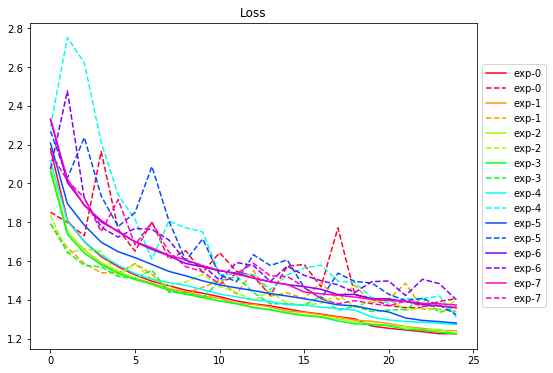

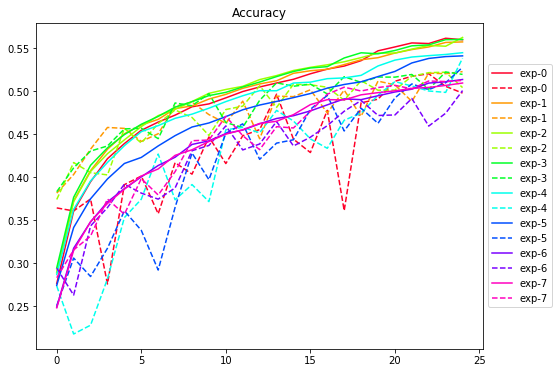

In [9]:
import matplotlib.pyplot as plt
import matplotlib.cm as mplcm
import matplotlib.colors as colors
%matplotlib inline
NUM_COLORS = len(results.keys())

cm = plt.get_cmap('gist_rainbow')
cNorm  = colors.Normalize(vmin=0, vmax=NUM_COLORS-1)
scalarMap = mplcm.ScalarMappable(norm=cNorm, cmap=cm)
color_bar = [scalarMap.to_rgba(i) for i in range(NUM_COLORS)]

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-loss'])),results[cond]['train-loss'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-loss'])),results[cond]['valid-loss'], '--', label=cond, color=color_bar[i])
plt.title("Loss")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-acc'])),results[cond]['train-acc'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-acc'])),results[cond]['valid-acc'], '--', label=cond, color=color_bar[i])
plt.title("Accuracy")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()